# Import section

In [1]:
from sys import exit
from stage2 import *

import numpy as np
from astropy.io.votable import parse
from astropy.table import Table
import matplotlib.lines as mlines
from matplotlib.cm import get_cmap

# Plotting the ramp model

/home/wilfried/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


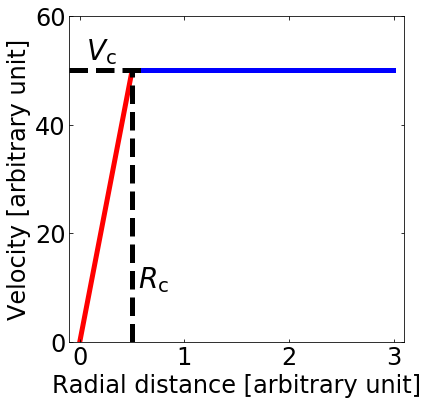

In [2]:
plt.rcParams["figure.figsize"] = (6, 6) # (w, h)
f = plt.figure()

#Data
xplateau = 0.5
slope    = 100
maxx     = 3
x        = np.arange(0, maxx, 0.01)
xint     = x[x<xplateau]
xout     = x[x>=xplateau]
yint     = np.asarray([slope*i for i in xint])
yout     = np.asarray([slope*xplateau for i in xout])

plt.xlim([0-0.1, maxx+0.1])
plt.ylim([0-0.1, slope*(xplateau+0.1)])

#Vertical line
vertlineX = [xplateau]*2
vertlineY = [0-0.1, slope*xplateau]

#Horizontal line
horilineX = [0-0.1, xplateau+0.1]
horilineY = [xplateau*slope]*2

asManyPlots(111, 
            [xint, xout, vertlineX, horilineX], 
            [yint, yout, vertlineY, horilineY],
            xlabel="Radial distance [arbitrary unit]", ylabel="Velocity [arbitrary unit]",
            linestyle=["-", "-", "--", "--"], marker=[None, None, None, None],
            color=['red', 'blue', 'black', 'black'],
            removeGrid=True,
            linewidth=5
            )

plt.text(xplateau+0.02*maxx, 0.2*slope*xplateau, r'$R_{\rm{c}}$', size=28)
plt.text(0.02*maxx, slope*(xplateau+0.02), r'$V_{\rm{c}}$', size=28)

plt.savefig('presentations/Friday/graphics/ramp_model.pdf', bbox_inches='tight')

# Checking axial ratio between Cassata and Zurich

## Opening file and checking file type

In [ ]:
pathdata = "outputs/"
data     = ["matching_fieldGals_Cassata_and_Zurich_corrected_radius_v2.vot"]

for name in data:
    voTag = is_VOtable(pathdata+name)
    if voTag:        
        fullFileName = pathdata + name
        #Retrieving the data
        table = parse(fullFileName)
        full  = table.get_first_table()
        
        print("Size of", name, "is", full.array.shape[0], "\n")
    else:
        exit("Exiting")

## Getting data

In [ ]:
catalog = parse(pathdata+data[0]).get_first_table().array
fields  = np.asarray(catalog.dtype.names)

#Converting to an astropy table for simplicity
table = Table(catalog)

## Getting wanted fields

In [ ]:
b_a_Cassata = table['Axial_Ratio_CASSATA']
a_b_Zurich  = table['ACS_ELONGATION_ZURICH']
size        = table['Corrected_radius'] #*0.03 #in arcsec

b_a_Cass2   = table['Axial_Ratio_CASSATA']
ell_Zurich  = table['ELL_GIM2D_ZURICH']
le_Zurich   = table['LE_ELL_GIM2D_ZURICH']
ue_Zurich   = table['UE_ELL_GIM2D_ZURICH']
size2       = table['Corrected_radius'] #*0.03

# Removing gals without Zurich info
m = np.where(a_b_Zurich != -9999)
b_a_Cassata, a_b_Zurich, size = applyMask([b_a_Cassata, a_b_Zurich, size], m)

print("There are", np.shape(b_a_Cassata)[0], "galaxies for this comparison.")

# Removing gals without GIM2D info
m = maskToRemoveVal([ell_Zurich, le_Zurich, ue_Zurich])
m = np.logical_and(m, maskToRemoveVal([ell_Zurich, le_Zurich, ue_Zurich], val=-9999, keep=False))
ell_Zurich, le_Zurich, ue_Zurich, b_a_Cass2, size2 = applyMask([ell_Zurich, le_Zurich, ue_Zurich, b_a_Cass2, size2], m)

print("There are", np.shape(b_a_Cass2)[0], "galaxies for this analysis.")

__Infos__:

- 261 field galaxies with corrected radius
- 176 after removing those without Zurich's SExtractor b/a
- 57 after removing those without GIM2D b/a

Hence 67\% have two measurements and 22\% have three measurements of b/a.

## Plotting

In [ ]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

b_a_Zurich = 1.0/a_b_Zurich
b_a_GIM2D  = 1.0-ell_Zurich
le_baGIM2D = np.abs(le_Zurich)*b_a_GIM2D*b_a_GIM2D
ue_baGIM2D = np.abs(ue_Zurich)*b_a_GIM2D*b_a_GIM2D

errors = [le_baGIM2D, ue_baGIM2D]
plt.errorbar(b_a_Cass2, b_a_GIM2D, yerr=errors, color='k', linestyle='None', zorder=1, capsize=3)

Sextractor = mlines.Line2D([], [], color='black', marker='o', markersize=12, fillstyle='none', label=r'SExtractor b/a', linestyle='None')
GIM2D      = mlines.Line2D([], [], color='black', marker='o', markersize=12, label='GIMD2D b/a', linestyle='None')
plt.legend(handles=[Sextractor, GIM2D], loc='best', prop={'size': 24}, shadow=True, fancybox=True)

line = [np.min(b_a_Cassata), np.max(b_a_Cassata)]
asManyPlots(111, [b_a_Cassata, b_a_Cass2, line], [b_a_Zurich, b_a_GIM2D, line], 
            marker=["o", "o", "None"],
            unfilledFlag=[True, False, False],
            zorder=[3, 2, 0],
            color=[size, size2, 'k'],
            plotFlag=[False, False, True],
            linestyle=['None', 'None', "--"],
            cmap='plasma_r',
            showColorbar=True,
            colorbarLabel=r'$R_{1/2} \,\, [\rm{px}]$',
            colorbarTicksLabelsSize=24,
            tickSize=26,
            textsize=26,
            legendTextSize=24,
            markerSize=80,
            cmapMax=10,
            ylabel=r"$\rm{Zurich} \ \ b/a$", xlabel=r"$\rm{Cassata} \ \ b/a$",
            outputName='Plots/checkMorpho/check_b_a.pdf', overwrite=True)

print(np.std(b_a_Zurich-b_a_Cassata))
print(np.std(b_a_GIM2D-b_a_Cass2))
print(np.shape(b_a_Zurich))

# Comparing Cassata's b/a with that of GalFit

## Opening file and checking file type

In [ ]:
pathdata = "outputs/"
data     = ["matching_clusterGals_with_Cassata_acc_1_arcsec.vot"]

for name in data:
    voTag = is_VOtable(pathdata+name)
    if voTag:        
        fullFileName = pathdata + name
        #Retrieving the data
        table = parse(fullFileName)
        full  = table.get_first_table()
        
        print("Size of", name, "is", full.array.shape[0], "\n")
    else:
        exit("Exiting")

## Getting data

In [ ]:
catalog = parse(pathdata+data[0]).get_first_table().array
fields  = np.asarray(catalog.dtype.names)

#Converting to an astropy table for simplicity
table = Table(catalog)

## Getting wanted fields

In [ ]:
b_a_Cassata = table['Axial_Ratio']
b_a_GF      = table['b_a_d_GF']
db_a_GF     = table['db_a_d_GF']
mag_d_GF    = table['Mag_d_GF']
mag_b_GF    = table['Mag_b_GF']
R_half      = table['R_HALF']

# Removing gals without Zurich info
m = np.where(np.logical_and(b_a_GF != -999, db_a_GF<1))
b_a_Cassata, b_a_GF, db_a_GF, mag_d_GF, mag_b_GF, R_half = applyMask([b_a_Cassata, b_a_GF, db_a_GF, mag_d_GF, mag_b_GF, R_half], m)

# Correcting size
offset  = -3.495e-1
A       = 1.95e-3
R_half /= (1+offset+A*R_half)

## Separating between gals with dominating disk and with dominating bulge

In [ ]:
color  = mag_d_GF - mag_b_GF
b_a_CassataB, b_a_GFB, colorB = applyMask([b_a_Cassata, b_a_GF, color], np.where(color>=0))
b_a_CassataD, b_a_GFD, colorD = applyMask([b_a_Cassata, b_a_GF, color], np.where(color<0))

## Plotting with magnitude colour coding

In [ ]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

errors = db_a_GF
plt.errorbar(b_a_Cassata, b_a_GF, yerr=errors, color='k', linestyle='None', zorder=1, capsize=3)

disk  = mlines.Line2D([], [], color='black', marker='d', markersize=12, label='Disk dominated', linestyle='None')
bulge = mlines.Line2D([], [], color='black', marker='o', markersize=12, label='Bulge dominated', linestyle='None')
plt.legend(handles=[disk, bulge], loc='best', prop={'size': 24}, shadow=True, fancybox=True)

line = [np.min(b_a_Cassata), np.max(b_a_Cassata)]
asManyPlots(111, [b_a_CassataB, b_a_CassataD, line], [b_a_GFB, b_a_GFD, line], 
            marker=["o", "d", "None"],
            unfilledFlag=[False, False, True],
            zorder=[3, 2, 0],
            color=[colorB, colorD, 'k'],
            cmapMin=np.min(color), cmapMax=np.max(color),
            plotFlag=[False, False, True],
            linestyle=['None', 'None', "--"],
            showColorbar=True,
            colorbarLabel=r"$M_{\rm{d}}^{\rm{GF}} - M_{\rm{b}}^{\rm{GF}} \ \ [\rm{mag}]$",
            colorbarTicksLabelsSize=24,
            tickSize=26,
            textsize=26,
            legendTextSize=24,
            markerSize=80,
            cmap='plasma_r',
            ylabel=r"$\rm{Galfit \,\, disk \,\, b/a}$", xlabel=r"$\rm{Cassata \,\, b/a}$",
            outputName='Plots/checkMorpho/check_b_a_GF.pdf', overwrite=True)

## Plotting with size colour coding

In [ ]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

errors = db_a_GF
plt.errorbar(b_a_Cassata, b_a_GF, yerr=errors, color='k', linestyle='None', zorder=1, capsize=3)

line = [np.min(b_a_Cassata), np.max(b_a_Cassata)]
asManyPlots(111, [b_a_Cassata, line], [b_a_GF, line], 
            marker=["o", "None"],
            zorder=[3, 0],
            color=[R_half, 'k'],
            cmapMin=np.min(R_half), cmapMax=30,
            plotFlag=[False, True],
            linestyle=['None', "--"],
            showColorbar=True,
            colorbarTicksLabelsSize=24,
            tickSize=26,
            textsize=26,
            legendTextSize=24,
            markerSize=80,
            colorbarLabel=r"$R_{1/2} \,\, [\rm{px}]$",
            cmap='plasma',
            ylabel=r"$\rm{Galfit \,\, disk \,\, b/a}$", xlabel=r"$\rm{Cassata \,\, SExtractor \,\, b/a}$",
            outputName='Plots/checkMorpho/check_b_a_GF_sizeCoding.pdf', overwrite=False)

# Plotting how the error on the inclination evolves with b/a

## Against absolute error on b/a

In [ ]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

ax1 = plt.subplot(111)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(which='both', direction='in', labelsize=26)

def errorb_a(b_a, delta):
    return delta*np.sqrt(np.abs(b_a*(2-b_a)))

b_a     = np.arange(0.01, 1, 0.01)
Delta_i = np.arange(0.01, 0.5, 0.01)

X, Y = np.meshgrid(b_a, Delta_i)
Z    = errorb_a(X, Y)

Y   *= 180/np.pi

tmp = ax1.contourf(X, Y, Z, 30, cmap='viridis')
tm  = ax1.contour(X, Y, Z, 10, colors='k', linestyles="--")
tm.clabel(fontsize=20)

plt.xlabel(r'$b/a$', size=26)
plt.ylabel(r'$\Delta i \,\, (\rm{deg})$', size=26)

col = plt.colorbar(tmp)
col.set_label(r'$\Delta (b/a)$', size=26)
col.ax.tick_params(labelsize=22) 

plt.savefig('Plots/Error_on_inc_versus_b_a.pdf', bbox_inches='tight')

## Against error on b/a

In [ ]:
from matplotlib.colors import LogNorm

plt.rcParams["figure.figsize"] = (24, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.25, hspace=0.05)

ax1 = plt.subplot(121)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(which='both', direction='in', labelsize=26)

def errorb_a(b_a, delta):
    return delta*np.sqrt(np.abs(b_a*(2-b_a)))

b_a     = np.arange(0.01, 1, 0.01)
Delta_i = np.arange(0.01, 0.5, 0.01)

X, Y = np.meshgrid(b_a, Delta_i)
Z    = errorb_a(X, Y)

Y   *= 180/np.pi

tmp = ax1.contourf(X, Y, Z, 30, cmap='viridis')
tm  = ax1.contour(X, Y, Z, 10, colors='k', linestyles="--")
tm.clabel(fontsize=20)

plt.xlabel(r'$b/a$', size=26)
plt.ylabel(r'${\rm{Uncertainty \,\, on \,\,}} i \,\, (\rm{deg})$', size=26)

col = plt.colorbar(tmp)
col.set_label(r'${\rm{Absolute \,\, error \,\, on \,\,}} b/a$', size=26)
col.ax.tick_params(labelsize=22)



ax1 = plt.subplot(122)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(which='both', direction='in', labelsize=26)

def errorb_a(b_a, delta):
    return delta*np.sqrt(np.abs(b_a*(2-b_a)))

b_a     = np.arange(0.01, 1, 0.01)
Delta_i = np.arange(0.01, 0.5, 0.01)

X, Y    = np.meshgrid(b_a, Delta_i)
Z       = errorb_a(X, Y)/X

Y      *= 180/np.pi

levels2 = np.linspace(np.log(np.min(Z)), np.log(np.max(Z)), 30)
levels2 = np.exp(levels2)
tmp     = ax1.contourf(X, Y, Z, levels=levels2, cmap='viridis', norm=LogNorm())


levels  = np.linspace(np.log(np.min(Z)), np.log(np.max(Z)), 10)
levels  = np.exp(levels)
tm      = ax1.contour(X, Y, Z, levels=levels, colors='k', linestyles="--", norm=LogNorm())
tm.clabel(fontsize=20)

tp      = ax1.contour(X, Y, Z, levels=[1.0], colors='r', linestyles="-.")
tp.clabel(fontsize=22)

tp      = ax1.contour(X, Y, Z, levels=[0.5], colors='r', linestyles="-.")
tp.clabel(fontsize=22)

plt.xlabel(r'$b/a$', size=26)
plt.ylabel(r'${\rm{Uncertainty \,\, on \,\,}} i \,\, (\rm{deg})$', size=26)

col = plt.colorbar(tmp)
col.set_label(r'${\rm{Relative \,\, error \,\, on \,\,}} b/a$', size=26)
col.ax.tick_params(labelsize=22)

col.set_ticklabels([round(i, 2) for i in col.get_ticks()])

plt.savefig('Plots/RelError_on_inc_versus_b_a.pdf', bbox_inches='tight')

# Plot theoretical angular momentum distribution

## Simple ramp model, velocity vector in the plane of the galaxy

In [2]:
def velocity(r, Rc, Vc):
    ret                       = np.copy(r)
    mask                      = r<Rc
    ret[mask]                 = Vc*r[mask]/Rc
    ret[np.logical_not(mask)] = Vc
    return ret

def momentum(r, v, theta):
    return r*v*np.cos(2*theta)

In [19]:
x = np.arange(-5, 5, 0.01)
y = np.arange(-5, 5, 0.01)

X, Y = np.meshgrid(x,y)

THETA  = np.arctan2(Y, X)
RADIUS = np.sqrt(X**2 + Y**2) 
SRAD   = np.copy(RADIUS)

### Checking the grid is correctly defined

Text(0, 0.5, '$Y \\, (\\rm{px})$')

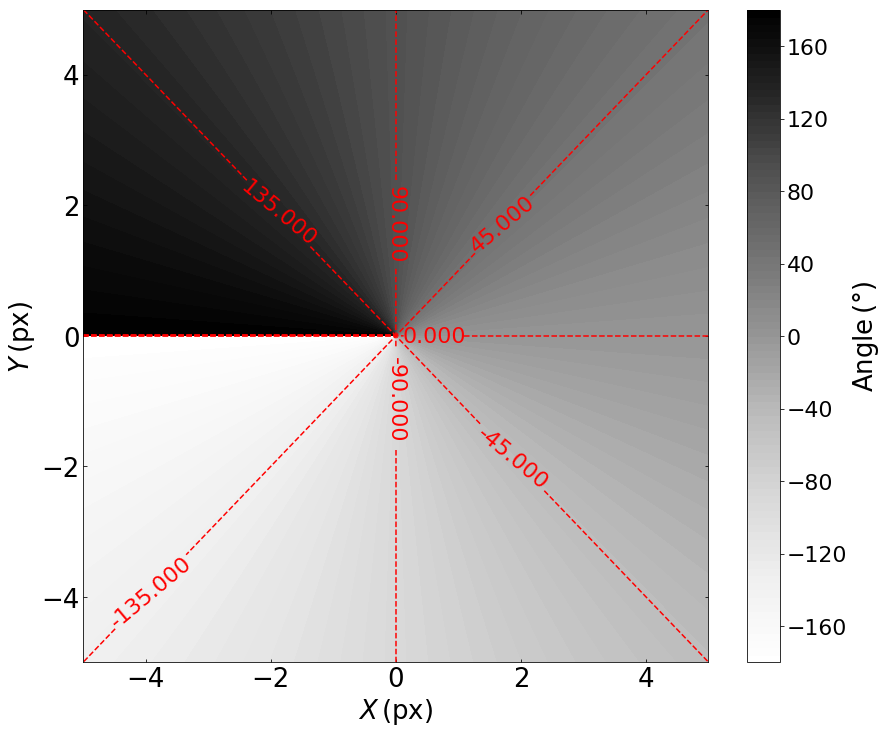

In [10]:
plt.rcParams["figure.figsize"] = (14, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.25, hspace=0.05)

ax1 = plt.subplot(111)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(which='both', direction='in', labelsize=26)

tmp = ax1.contourf(X, Y, THETA*180/np.pi, levels=100, cmap='Greys')
tp  = ax1.contour(X, Y, THETA*180/np.pi, levels=[ -135, -90, -45, 0, 45, 90, 135], linestyles="--", colors='red')
tp.clabel(fontsize=22)

col = plt.colorbar(tmp)
col.set_label(r'$\rm{Angle \, (\degree)}$', size=26)
col.ax.tick_params(labelsize=22)

plt.xlabel(r'$X \, (\rm{px})$', size=26)
plt.ylabel(r'$Y \, (\rm{px})$', size=26)

Text(0, 0.5, '$Y \\, (\\rm{px})$')

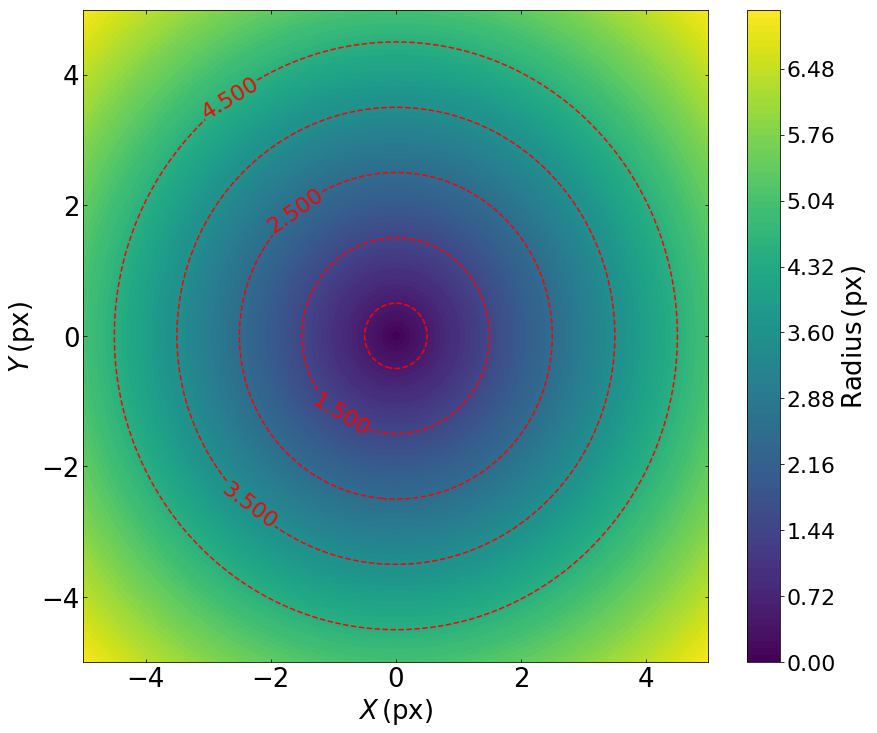

In [11]:
plt.rcParams["figure.figsize"] = (14, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.25, hspace=0.05)

ax1 = plt.subplot(111)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(which='both', direction='in', labelsize=26)

tmp = ax1.contourf(X, Y,RADIUS, levels=100, cmap='viridis')
tp  = ax1.contour(X, Y, RADIUS, levels=[0.5, 1.5, 2.5, 3.5, 4.5], linestyles="--", colors='red')
tp.clabel(fontsize=22)

col = plt.colorbar(tmp)
col.set_label(r'$\rm{Radius \, (px)}$', size=26)
col.ax.tick_params(labelsize=22)

plt.xlabel(r'$X \, (\rm{px})$', size=26)
plt.ylabel(r'$Y \, (\rm{px})$', size=26)

### Checking velocity field

Text(0, 0.5, '$Y \\, (\\rm{px})$')

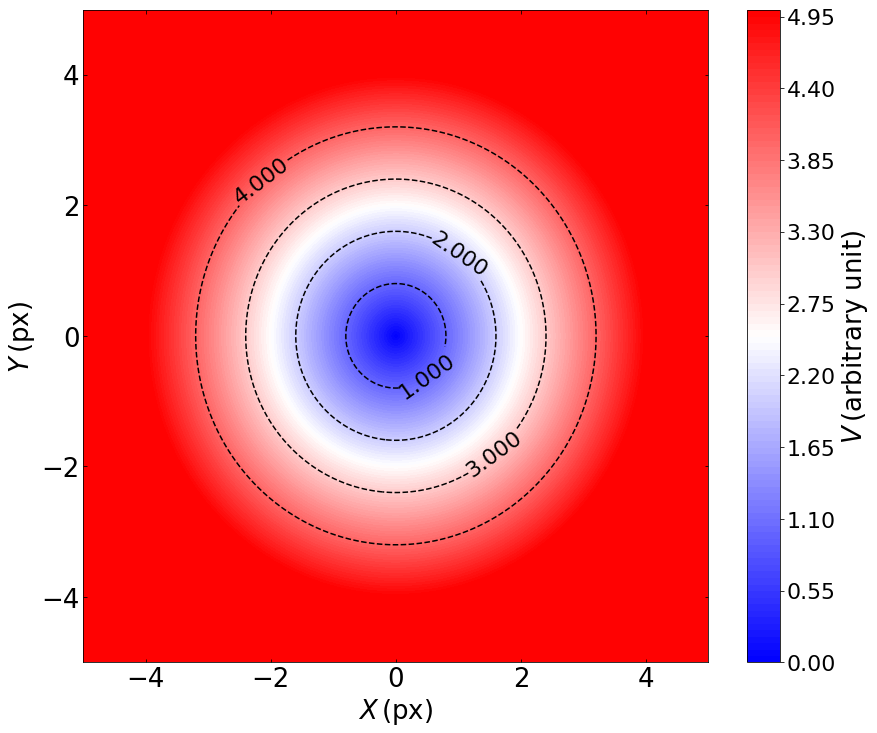

In [32]:
vel = velocity(RADIUS, 4, 5)

plt.rcParams["figure.figsize"] = (14, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.25, hspace=0.05)

ax1 = plt.subplot(111)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(which='both', direction='in', labelsize=26)

tmp = ax1.contourf(X, Y, vel, levels=100, cmap='bwr')
tp  = ax1.contour(X, Y, vel, levels=4, linestyles="--", colors='k')
tp.clabel(fontsize=22)

col = plt.colorbar(tmp)
col.set_label(r'$V \, (\rm{arbitrary \,\, unit})$', size=26)
col.ax.tick_params(labelsize=22)

plt.xlabel(r'$X \, (\rm{px})$', size=26)
plt.ylabel(r'$Y \, (\rm{px})$', size=26)

### Specific angular momentum (z component) plot

Text(0, 0.5, '$Y \\, (\\rm{px})$')

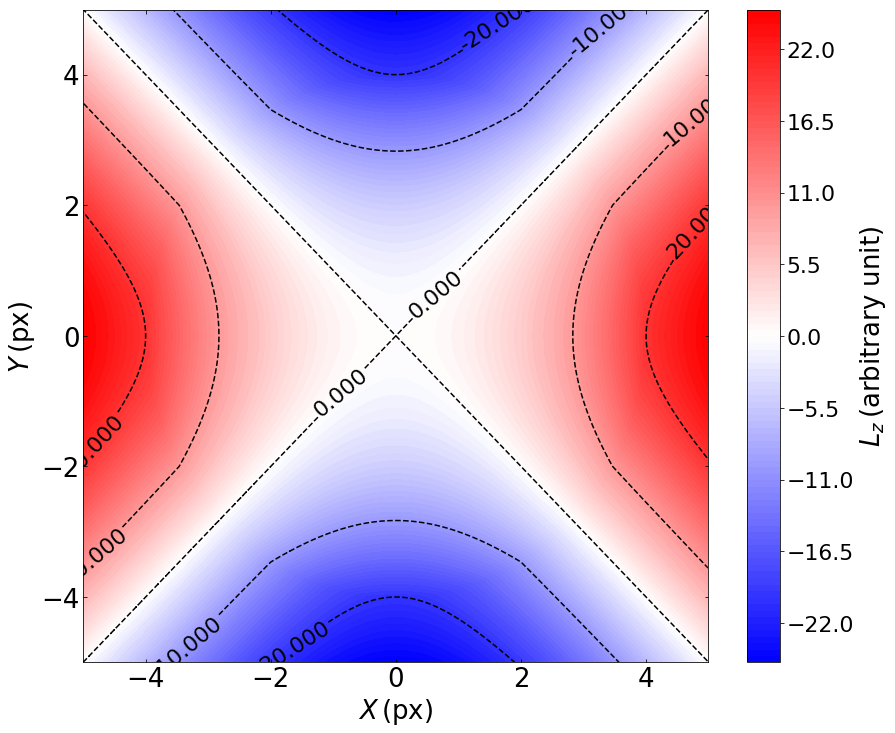

In [33]:
Lz = momentum(RADIUS, vel, THETA)

plt.rcParams["figure.figsize"] = (14, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.25, hspace=0.05)

ax1 = plt.subplot(111)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(which='both', direction='in', labelsize=26)

tmp = ax1.contourf(X, Y, Lz, levels=100, cmap='bwr')
tp  = ax1.contour(X, Y, Lz, levels=5, linestyles="--", colors='k')
tp.clabel(fontsize=22)

col = plt.colorbar(tmp)
col.set_label(r'$L_z \, (\rm{arbitrary \,\, unit})$', size=26)
col.ax.tick_params(labelsize=22)

plt.xlabel(r'$X \, (\rm{px})$', size=26)
plt.ylabel(r'$Y \, (\rm{px})$', size=26)

### (x and y components plots)

Text(0, 0.5, '$Y \\, (\\rm{px})$')

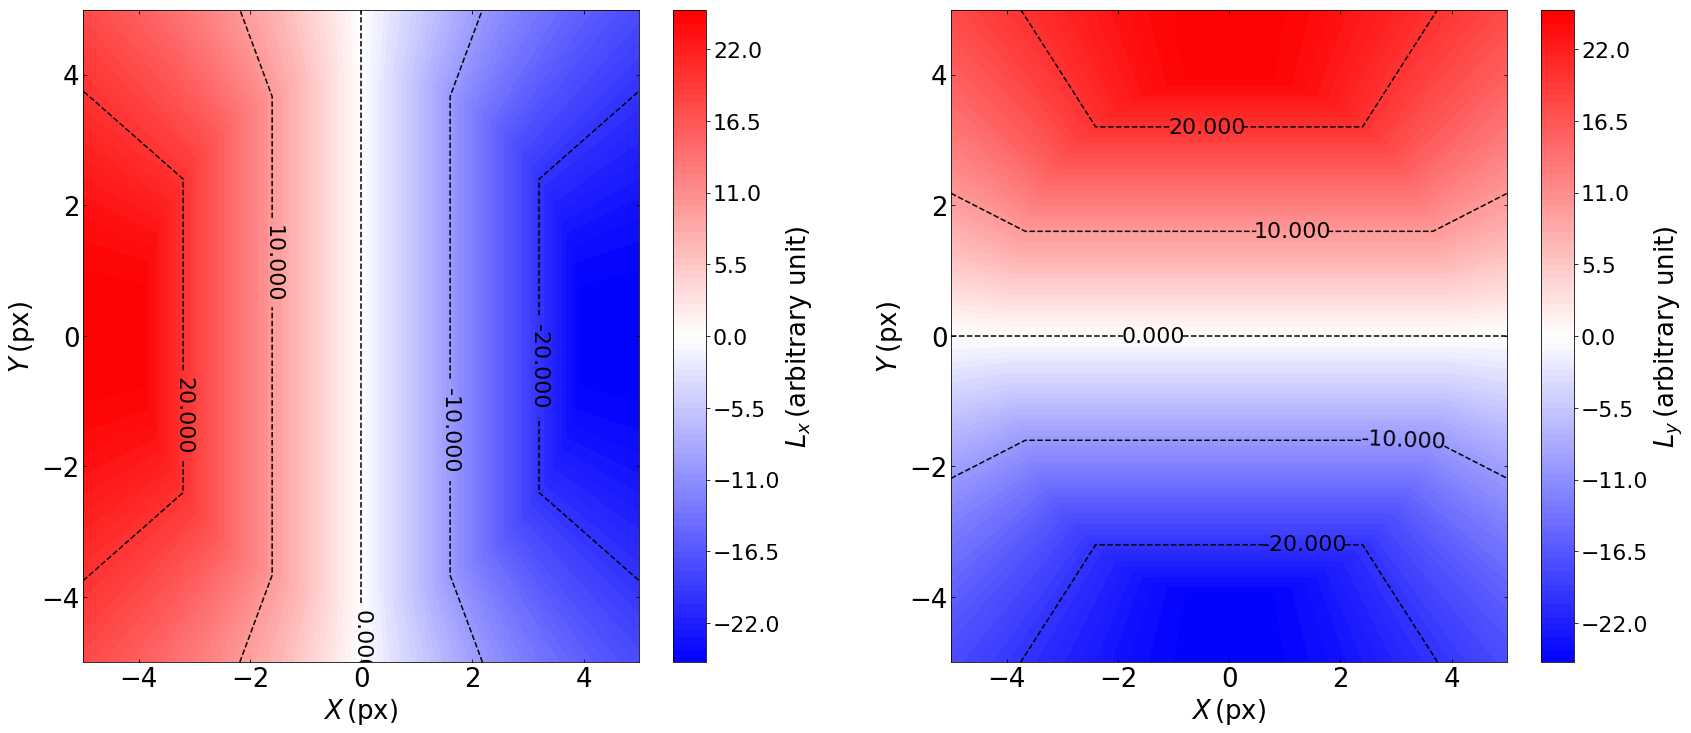

In [34]:
z = 5

Lx = -z*vel*np.cos(THETA)
Ly = z*vel*np.sin(THETA)

plt.rcParams["figure.figsize"] = (28, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.25, hspace=0.05)

ax1 = plt.subplot(121)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(which='both', direction='in', labelsize=26)

tmp = ax1.contourf(X, Y, Lx, levels=100, cmap='bwr')
tp  = ax1.contour(X, Y, Lx, levels=5, linestyles="--", colors='k')
tp.clabel(fontsize=22)

col = plt.colorbar(tmp)
col.set_label(r'$L_x \, (\rm{arbitrary \,\, unit})$', size=26)
col.ax.tick_params(labelsize=22)

plt.xlabel(r'$X \, (\rm{px})$', size=26)
plt.ylabel(r'$Y \, (\rm{px})$', size=26)

ax1 = plt.subplot(122)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(which='both', direction='in', labelsize=26)

tmp = ax1.contourf(X, Y, Ly, levels=100, cmap='bwr')
tp  = ax1.contour(X, Y, Ly, levels=5, linestyles="--", colors='k')
tp.clabel(fontsize=22)

col = plt.colorbar(tmp)
col.set_label(r'$L_y \, (\rm{arbitrary \,\, unit})$', size=26)
col.ax.tick_params(labelsize=22)

plt.xlabel(r'$X \, (\rm{px})$', size=26)
plt.ylabel(r'$Y \, (\rm{px})$', size=26)

### z variation of Lx and Ly at fixed $\theta$

In [4]:
Radial_distance = np.arange(0, 5, 0.01)
RR, ZZ          = np.meshgrid(Radial_distance, y)

LL = ZZ*velocity(RR, 4, 5)

Text(0, 0.5, '$Z \\, (\\rm{px})$')

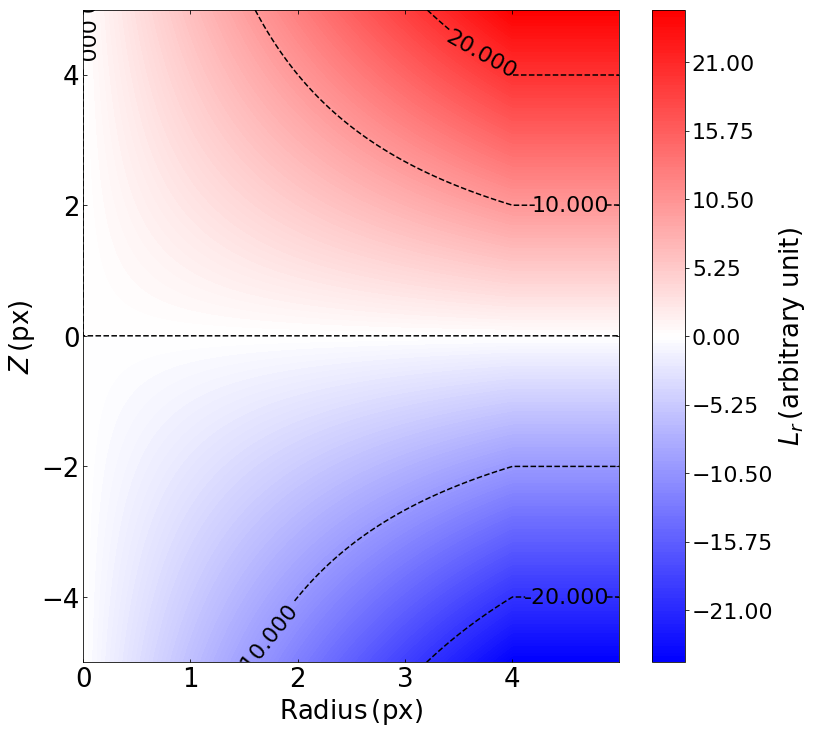

In [17]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.25, hspace=0.05)

ax1 = plt.subplot(111)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(which='both', direction='in', labelsize=26)

tmp = ax1.contourf(RR, ZZ, LL, levels=200, cmap='bwr')
tp  = ax1.contour(RR, ZZ, LL, levels=5, linestyles="--", colors='k')
tp.clabel(fontsize=22)

col = plt.colorbar(tmp)
col.set_label(r'$L_r \, (\rm{arbitrary \,\, unit})$', size=26)
col.ax.tick_params(labelsize=22)

plt.xlabel(r'$\rm{Radius \, (px)}$', size=26)
plt.ylabel(r'$Z \, (\rm{px})$', size=26)